## 1. Загрузка данных 

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Загрзка данных
df = pd.read_csv('air_quality.csv')

# 2. Подготовка данных
# Разделяем признаки и целевую переменную
X = df.drop('air_quality', axis=1)
y = df['air_quality']


## 2. Подготовьте данные к обучению - 1 балл

- Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией. В качестве целевой переменной используйте столбец air_quality - бинарный столбец (0 - плохое качество воздуха, 1 - хорошее качество воздуха).

- Создайте объекты для работы с данными в PyTorch - Dataset и DataLoader для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, batch_size.

In [6]:
# Разделяем данные на обучающую+валидационную и тестовую выборки (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Разделяем обучающую+валидационную выборку на обучающую и валидационную (75/25)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

In [7]:
# Создаем класс для работы с данными
class AirQualityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создаем объекты Dataset
train_dataset = AirQualityDataset(X_train, y_train)
val_dataset = AirQualityDataset(X_val, y_val)
test_dataset = AirQualityDataset(X_test, y_test)

# Создаем объекты DataLoader
# Используем batch_size=32, что является распространенным выбором,
# обеспечивающим хороший баланс между скоростью обучения и памятью
batch_size = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

# Проверка размеров выборок
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

Размер обучающей выборки: 3000
Размер валидационной выборки: 1000
Размер тестовой выборки: 1000


## 3. Реализуйте класс нейросетевой модели для решения задачи - 1 балл

- Минимальное количество Linear слоев в структуре - 3 штуки: входной слой, скрытый слой, выходной классификационный слой.
- Подберите оптимальные для задачи функции активации - ReLU, Sigmoid, Tanh, LeakyReLU...
- Реализуйте логику прохождения данных по сети в методе forward
- Cоздайте объект модели, реализуйте перевод модели на gpu

Примечание: в качестве устрйо ства я указал свой девайс cuda:0. девайс может отличатсья взависимости от конфигурации вашего ПК

In [8]:
import torch
import torch.nn as nn

class AirQualityNet(nn.Module):
    def __init__(self, input_size):
        super(AirQualityNet, self).__init__()
        
        # Определяем архитектуру сети
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),  # Batch Normalization для стабилизации обучения
            nn.ReLU(),          # ReLU для первого слоя
            nn.Dropout(0.3)     # Dropout для предотвращения переобучения
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Выходной слой с sigmoid активацией, т.к. у нас бинарная классификация
        self.layer3 = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x.squeeze()  # squeeze убирает размерность = 1

# Получаем размерность входного слоя из данных
input_size = X_train.shape[1]

# Создаем объект модели
model = AirQualityNet(input_size)

# Проверяем доступность GPU и переносим модель на него
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Модель использует устройство: {device}")
print("\nСтруктура модели:")
print(model)

Модель использует устройство: cuda:0

Структура модели:
AirQualityNet(
  (layer1): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


## 4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте значения функции потерь на тренировочной и валидационной выборках - 1 балл

Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [00:03<00:00, 24.18it/s]


Epoch [1/30]
Training Loss: 0.4691
Validation Loss: 0.3322
--------------------------------------------------


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 245.43it/s]


Epoch [2/30]
Training Loss: 0.2750
Validation Loss: 0.2041
--------------------------------------------------


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 236.18it/s]


Epoch [3/30]
Training Loss: 0.2129
Validation Loss: 0.1690
--------------------------------------------------


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 246.72it/s]


Epoch [4/30]
Training Loss: 0.1957
Validation Loss: 0.1753
--------------------------------------------------


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.12it/s]


Epoch [5/30]
Training Loss: 0.1607
Validation Loss: 0.1495
--------------------------------------------------


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.13it/s]


Epoch [6/30]
Training Loss: 0.1738
Validation Loss: 0.1499
--------------------------------------------------


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.83it/s]


Epoch [7/30]
Training Loss: 0.1713
Validation Loss: 0.1313
--------------------------------------------------


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 255.43it/s]


Epoch [8/30]
Training Loss: 0.1651
Validation Loss: 0.1424
--------------------------------------------------


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 258.95it/s]


Epoch [9/30]
Training Loss: 0.1646
Validation Loss: 0.1233
--------------------------------------------------


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 253.37it/s]


Epoch [10/30]
Training Loss: 0.1612
Validation Loss: 0.1194
--------------------------------------------------


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 250.67it/s]


Epoch [11/30]
Training Loss: 0.1511
Validation Loss: 0.1230
--------------------------------------------------


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 210.28it/s]


Epoch [12/30]
Training Loss: 0.1549
Validation Loss: 0.1456
--------------------------------------------------


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 255.44it/s]


Epoch [13/30]
Training Loss: 0.1612
Validation Loss: 0.1125
--------------------------------------------------


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 251.34it/s]


Epoch [14/30]
Training Loss: 0.1474
Validation Loss: 0.1134
--------------------------------------------------


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 256.13it/s]


Epoch [15/30]
Training Loss: 0.1468
Validation Loss: 0.1067
--------------------------------------------------


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 251.34it/s]


Epoch [16/30]
Training Loss: 0.1538
Validation Loss: 0.1113
--------------------------------------------------


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 227.60it/s]


Epoch [17/30]
Training Loss: 0.1544
Validation Loss: 0.1294
--------------------------------------------------


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 245.44it/s]


Epoch [18/30]
Training Loss: 0.1506
Validation Loss: 0.1119
--------------------------------------------------


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 196.65it/s]


Epoch [19/30]
Training Loss: 0.1420
Validation Loss: 0.1074
--------------------------------------------------


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 199.58it/s]


Epoch [20/30]
Training Loss: 0.1524
Validation Loss: 0.1008
--------------------------------------------------


Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 232.67it/s]


Epoch [21/30]
Training Loss: 0.1380
Validation Loss: 0.1026
--------------------------------------------------


Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 236.78it/s]


Epoch [22/30]
Training Loss: 0.1456
Validation Loss: 0.0957
--------------------------------------------------


Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 238.58it/s]


Epoch [23/30]
Training Loss: 0.1280
Validation Loss: 0.0991
--------------------------------------------------


Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 230.39it/s]


Epoch [24/30]
Training Loss: 0.1326
Validation Loss: 0.1011
--------------------------------------------------


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 240.41it/s]


Epoch [25/30]
Training Loss: 0.1518
Validation Loss: 0.1279
--------------------------------------------------


Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 191.84it/s]


Epoch [26/30]
Training Loss: 0.1327
Validation Loss: 0.0990
--------------------------------------------------


Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 236.78it/s]


Epoch [27/30]
Training Loss: 0.1273
Validation Loss: 0.0971
--------------------------------------------------


Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 229.27it/s]


Epoch [28/30]
Training Loss: 0.1302
Validation Loss: 0.1074
--------------------------------------------------


Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 232.10it/s]


Epoch [29/30]
Training Loss: 0.1140
Validation Loss: 0.0983
--------------------------------------------------


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 236.78it/s]


Epoch [30/30]
Training Loss: 0.1335
Validation Loss: 0.1295
--------------------------------------------------


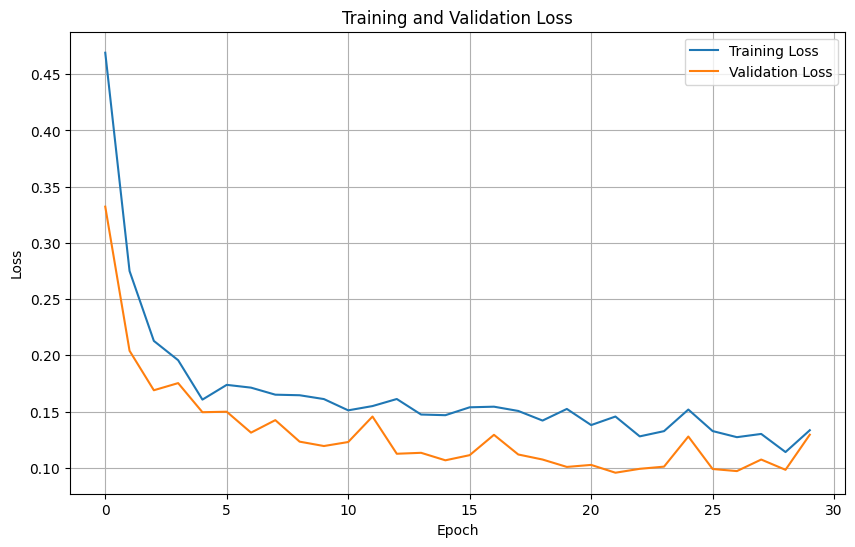

In [9]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Списки для хранения значений функции потерь
    train_losses = []
    val_losses = []
    
    # Основной цикл по эпохам
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            # Перемещаем данные на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            
            # Backward pass и оптимизация
            loss.backward()
            optimizer.step()
            
            # Накапливаем потери
            train_loss += loss.item()
            train_batches += 1
        
        # Вычисляем среднюю потерю за эпоху
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():  # Отключаем вычисление градиентов
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                
                # Накапливаем потери
                val_loss += loss.item()
                val_batches += 1
        
        # Вычисляем среднюю потерю на валидации
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Выводим результаты эпохи
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)
    
    return train_losses, val_losses

# Настройка обучения
criterion = nn.BCELoss()  # Binary Cross Entropy Loss для бинарной классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# Запуск обучения
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# Визуализация результатов обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Сохранение обученной модели
torch.save(model.state_dict(), 'air_quality_model.pth')

## 5. Обучите модель и проверьте ее качество - 1 балл

- Выберите оптимизатор, в качестве функции потерь используйте nn.BCELoss
- Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
- Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - classification_report


Обучение с learning rate: 0.001


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 222.64it/s]


Epoch [5/50]
Train Loss: 0.1911, Val Loss: 0.1466


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 251.34it/s]


Epoch [10/50]
Train Loss: 0.1568, Val Loss: 0.1214


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 240.10it/s]


Epoch [15/50]
Train Loss: 0.1488, Val Loss: 0.1312


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 250.00it/s]


Epoch [20/50]
Train Loss: 0.1596, Val Loss: 0.1080


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 239.80it/s]


Epoch [25/50]
Train Loss: 0.1288, Val Loss: 0.0960


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.75it/s]


Epoch [30/50]
Train Loss: 0.1156, Val Loss: 0.0935


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 260.39it/s]


Epoch [35/50]
Train Loss: 0.1256, Val Loss: 0.0782


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 258.95it/s]


Epoch [40/50]
Train Loss: 0.1378, Val Loss: 0.0813


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 249.94it/s]


Epoch [45/50]
Train Loss: 0.1189, Val Loss: 0.0840


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 248.68it/s]


Epoch [50/50]
Train Loss: 0.1325, Val Loss: 0.1102

Обучение с learning rate: 0.0001


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.74it/s]


Epoch [5/50]
Train Loss: 0.4223, Val Loss: 0.4068


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.06it/s]


Epoch [10/50]
Train Loss: 0.3142, Val Loss: 0.2935


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 230.96it/s]


Epoch [15/50]
Train Loss: 0.2615, Val Loss: 0.2314


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 202.15it/s]


Epoch [20/50]
Train Loss: 0.2245, Val Loss: 0.1983


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 215.10it/s]


Epoch [25/50]
Train Loss: 0.2087, Val Loss: 0.1780


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 263.31it/s]


Epoch [30/50]
Train Loss: 0.1970, Val Loss: 0.1643


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 264.04it/s]


Epoch [35/50]
Train Loss: 0.1872, Val Loss: 0.1569


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 213.15it/s]


Epoch [40/50]
Train Loss: 0.1883, Val Loss: 0.1534


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 241.03it/s]


Epoch [45/50]
Train Loss: 0.1804, Val Loss: 0.1477


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 254.06it/s]


Epoch [50/50]
Train Loss: 0.1759, Val Loss: 0.1391


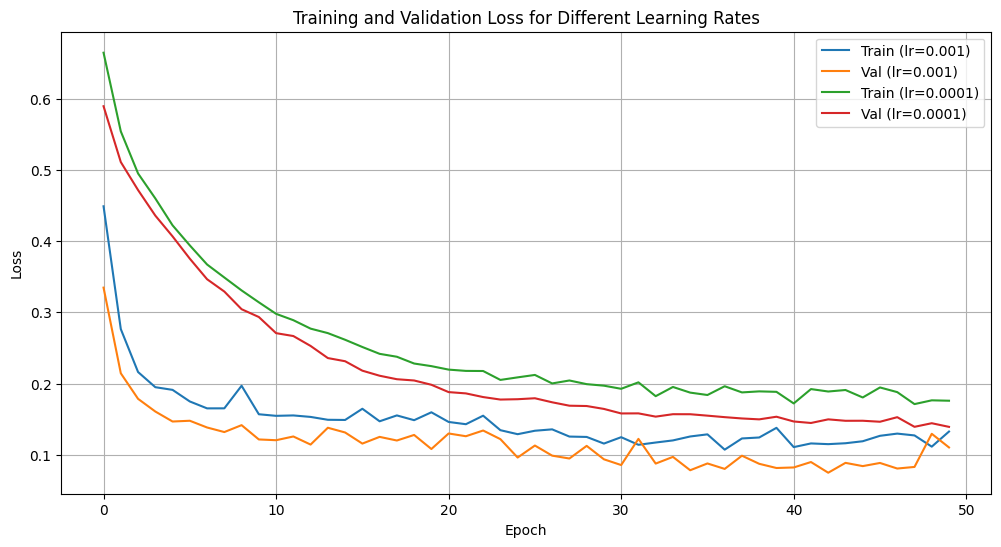


Лучший learning rate: 0.001

Отчет о классификации:
                  precision    recall  f1-score   support

 Плохое качество       1.00      0.89      0.94       300
Хорошее качество       0.95      1.00      0.98       700

        accuracy                           0.97      1000
       macro avg       0.98      0.94      0.96      1000
    weighted avg       0.97      0.97      0.97      1000



In [10]:
from sklearn.metrics import classification_report
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Функция для оценки модели на тестовой выборке
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float().cpu().numpy()
            all_predictions.extend(predicted)
            all_labels.extend(labels.numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Параметры обучения
learning_rates = [0.001, 0.0001]  # Попробуем разные learning rates
num_epochs = 50
best_val_loss = float('inf')
best_model_state = None

# Словарь для хранения результатов для разных learning rates
results = {}

for lr in learning_rates:
    print(f"\nОбучение с learning rate: {lr}")
    
    # Инициализируем модель и оптимизатор
    model = AirQualityNet(input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    # Списки для хранения потерь
    train_losses = []
    val_losses = []
    
    # Обучение модели
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Сохраняем лучшую модель
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }

# Визуализация результатов для разных learning rates
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results[lr]['train_losses'], label=f'Train (lr={lr})')
    plt.plot(results[lr]['val_losses'], label=f'Val (lr={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Выбираем лучший learning rate
best_lr = min(results.keys(), key=lambda x: results[x]['best_val_loss'])
print(f"\nЛучший learning rate: {best_lr}")

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Оцениваем модель на тестовой выборке
y_pred, y_true = evaluate_model(model, test_loader, device)

# Выводим отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_true, y_pred, target_names=['Плохое качество', 'Хорошее качество']))

# Сохраняем лучшую модель
torch.save({
    'model_state_dict': best_model_state,
    'learning_rate': best_lr,
    'best_val_loss': best_val_loss
}, 'best_air_quality_model.pth')

## Выводы: 

- Получилось обучить нейронную сеть дял предсказания качества воздуха. 
